# **Brain Decoding Lab**
In this `.ipynb` file, we are going to investigate the Brain Decoding stage as mini problem.
Brain decoding normally revoles around decoding the encoded information by brain into different kind of outputs. This output could be classification task like Human action recognition, or a gerative task, such as brain image decoding, and descovering the input stimuli.

Before we start, we need to import and install some important libraries to work with.

In [ ]:
%%capture
! pip install nilearn
! pip install h5py
! pip install nibabel
! pip install torch_geometric
! pip install pandas==1.3.5

In [ ]:
# Import libs
import numpy as np
import nibabel as nib
from nilearn import plotting
from nilearn.image import new_img_like
import h5py
import nilearn
from nilearn.input_data import NiftiLabelsMasker
import pandas as pd
import pickle
from collections import Counter
import warnings
warnings.filterwarnings(action='once')
import nilearn.connectome


<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


## **Friends Dataset**
Friends dataset, is the collection of Brain activities of the people watching Friends TV-series. This dataset is hosted by Institut universitaire de gériatrie de Montréal (IUGM). To visualize it, we use `from nilearn import plotting` for plotting the actual Brain image and the parcellations.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


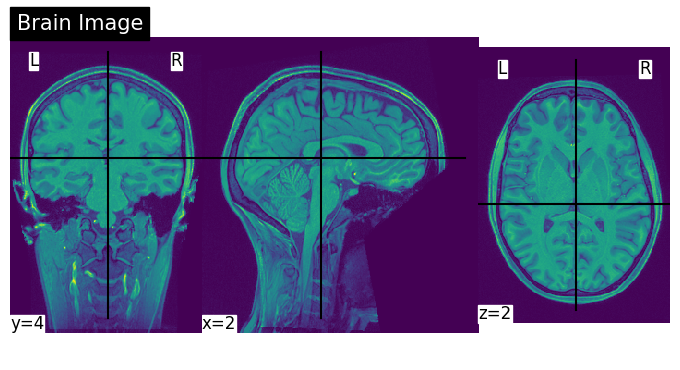

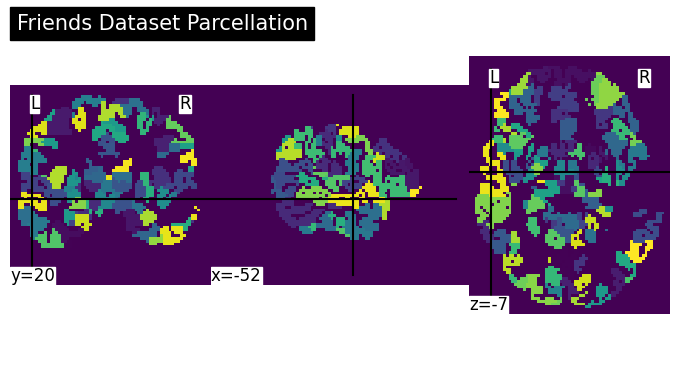

In [ ]:
from nilearn import plotting


Brain = '/content/drive/MyDrive/BrainHack_2024_2/sub-03/sub-03_desc-preproc_T1w.nii.gz'
plotting.plot_img(Brain, title='Brain Image')

parcellation3 = '/content/drive/MyDrive/BrainHack_2024_2/sub-03/sub-03_task-friends_space-T1w_atlas-Ward_desc-400_dseg.nii.gz'
plotting.plot_img(parcellation3, title='Friends Dataset Parcellation')

## **Things Dataset**
[Things dataset](https://things-initiative.org/), is a collection of brain activities (FMRI) data, for different categories.
Here we map the $\beta$ scores representation, of each voxcel to to 3d shape of the brain structure. And then we make an average over each parcel. Here the first image is the $\beta$ score mapping to the brain voxcels, and the second one is the average values of the $\beta$ over different paracels of the brain. Please note that $\beta$ score, is simply the coefficients of a linear model fitted to each FMRI signal voxcel.

Keys in the HDF5 file: ['acorn_01b', 'acorn_02n', 'acorn_03s', 'acorn_04s', 'acorn_05s', 'acorn_06s', 'airbag_01b', 'airbag_02s', 'airbag_03s', 'airbag_04s', 'airbag_05s', 'airbag_06s', 'aircraft_carrier_01b', 'aircraft_carrier_02s', 'aircraft_carrier_03s', 'aircraft_carrier_04s', 'aircraft_carrier_05s', 'aircraft_carrier_06s', 'airplane_01b', 'airplane_02n', 'airplane_03n', 'airplane_04n', 'airplane_05n', 'airplane_06n', 'alligator_01b', 'alligator_02s', 'alligator_03n', 'alligator_04s', 'alligator_05s', 'alligator_06s', 'aloe_01b', 'aloe_02s', 'aloe_03n', 'aloe_04s', 'aloe_05s', 'aloe_06s', 'altar_01b', 'altar_02s', 'altar_03s', 'altar_04s', 'altar_05s', 'altar_06s', 'aluminum_foil_01b', 'aluminum_foil_02s', 'aluminum_foil_03s', 'aluminum_foil_04s', 'aluminum_foil_05s', 'aluminum_foil_06s', 'anchor_01b', 'anchor_02s', 'anchor_03n', 'anchor_04s', 'anchor_05s', 'anchor_06s', 'anklet_01b', 'anklet_02s', 'anklet_03s', 'anklet_04s', 'anklet_05s', 'anklet_06s', 'ant_01b', 'ant_02s', 'ant_0

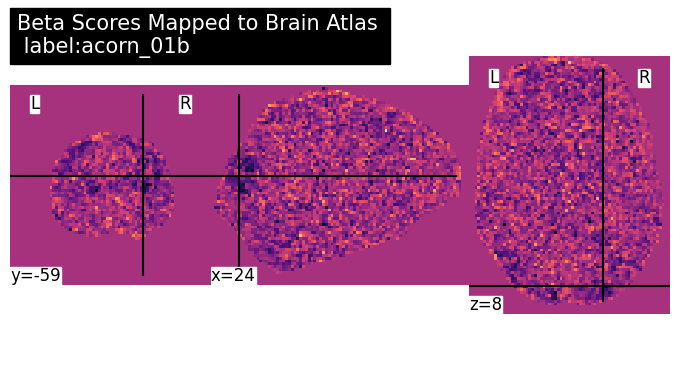

Shape of region signals:  (1, 400)
     Region  Average Signal
0       1.0       -0.112586
1       2.0       -0.004418
2       3.0        0.045564
3       4.0       -0.077944
4       5.0       -0.290445
..      ...             ...
395   396.0       -0.250721
396   397.0       -0.225610
397   398.0       -0.357176
398   399.0       -0.359945
399   400.0       -0.221157

[400 rows x 2 columns]


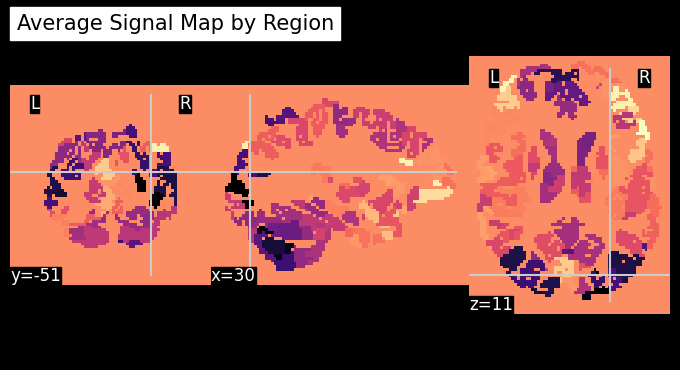

In [ ]:
import numpy as np
import nibabel as nib
import nilearn
from nilearn import plotting
from nilearn.image import new_img_like
import h5py
from nilearn.input_data import NiftiLabelsMasker
import pandas as pd
atlas_filename = '/content/drive/MyDrive/BrainHack_2024_2/sub-03/sub-03_task-friends_space-T1w_atlas-Ward_desc-400_dseg.nii.gz'
atlas_img = nib.load(atlas_filename)
atlas_data = atlas_img.get_fdata()

mask_file = '/content/drive/MyDrive/BrainHack_2024_2/sub-03/sub-03_task-things_space-T1w_label-brain_desc-unionNonNaN_mask.nii'
mask = nilearn.image.load_img(mask_file)
#print(mask)

file_path = '/content/drive/MyDrive/BrainHack_2024_2/sub-03/sub-03_task-things_space-T1w_model-fitHrfGLMdenoiseRR_stats-imageBetas_desc-zscore_statseries.h5'
# Open the HDF5 file
data = []
beta_scores = []
label_name = ''
with h5py.File(file_path, 'r') as f:
    print("Keys in the HDF5 file:", list(f.keys()))
    print(len(list(f.keys())))
    label_name = 'acorn_01b'
    #session_type = 'ses-001_task-s01e02a_timeseries'
    latent_type = 'betas'
    if label_name in f:
        data = f[label_name]
        print(f"Data in {label_name}:")
        print(data.keys())
        print(f"Data in {latent_type}:")
        print(data[latent_type])
        beta_scores = data[latent_type][:]
    else:
        print(f"Dataset {label_name} not found in the file.")


print('beta_scores shape', beta_scores.shape)
# Check if the length of beta scores matches the number of regions in the atlas
print('ATLAS shape', atlas_data.shape)

unmasked_beta = nilearn.masking.unmask(beta_scores, mask, order='F')

# Create a new Nifti image using the beta map
beta_map_img = unmasked_beta
# Plot the image
plotting.plot_img(beta_map_img, title='Beta Scores Mapped to Brain Atlas \n label:'+ label_name,cmap='magma')
plotting.show()

labels_masker = NiftiLabelsMasker(labels_img=atlas_img)
region_signals = labels_masker.fit_transform(beta_map_img)
print("Shape of region signals: ", region_signals.shape)
average_signals = np.mean(region_signals, axis=0)

# Load the atlas data to get region labels
atlas_data = atlas_img.get_fdata()

unique_regions = np.unique(atlas_data)[1:]

region_signal_df = pd.DataFrame({
    'Region': unique_regions,
    'Average Signal': average_signals
})

print(region_signal_df)

average_signal_map = np.zeros(atlas_data.shape)

for i, region in enumerate(unique_regions):
    average_signal_map[atlas_data == region] = average_signals[i]

average_signal_img = nib.Nifti1Image(average_signal_map, atlas_img.affine, atlas_img.header)

# Plot the average signal map
plotting.plot_img(average_signal_img, title='Average Signal Map by Region', black_bg=True, cmap='magma')
plotting.show()


###**Friends Dataset Connectome**
Here we plot the connectome of the Friends dataset, to get the connectivuty map of different Brain parcels together. Function `nilearn.connectome.ConnectivityMeasure` plots the connectomes, and `reorder=True` argument in `plotting.plot_matrix` makes it as correlation clustered regions in the Brain.

Keys in the HDF5 file: ['ses-001', 'ses-002', 'ses-003', 'ses-004', 'ses-005', 'ses-006', 'ses-007', 'ses-008', 'ses-009', 'ses-010', 'ses-011', 'ses-012', 'ses-013', 'ses-014', 'ses-015', 'ses-016', 'ses-017', 'ses-018', 'ses-019', 'ses-020', 'ses-021', 'ses-022', 'ses-023', 'ses-024', 'ses-025', 'ses-026', 'ses-027', 'ses-028', 'ses-029', 'ses-030', 'ses-031', 'ses-032', 'ses-033', 'ses-034', 'ses-035', 'ses-036', 'ses-037', 'ses-038', 'ses-039', 'ses-040', 'ses-041', 'ses-042', 'ses-043', 'ses-044', 'ses-045', 'ses-046', 'ses-047', 'ses-048', 'ses-049', 'ses-050', 'ses-052', 'ses-053', 'ses-054', 'ses-055', 'ses-056', 'ses-057', 'ses-058', 'ses-059', 'ses-060', 'ses-061', 'ses-062', 'ses-063', 'ses-065', 'ses-066', 'ses-067', 'ses-070', 'ses-071', 'ses-072', 'ses-074', 'ses-075', 'ses-076', 'ses-077', 'ses-078', 'ses-079', 'ses-080', 'ses-081', 'ses-082', 'ses-083']
78
Data in ses-030:
<KeysViewHDF5 ['ses-030_task-s03e06a_timeseries', 'ses-030_task-s03e06b_timeseries', 'ses-030_task

/usr/local/lib/python3.10/dist-packages/nilearn/connectome/connectivity_matrices.py:507: DeprecationWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [


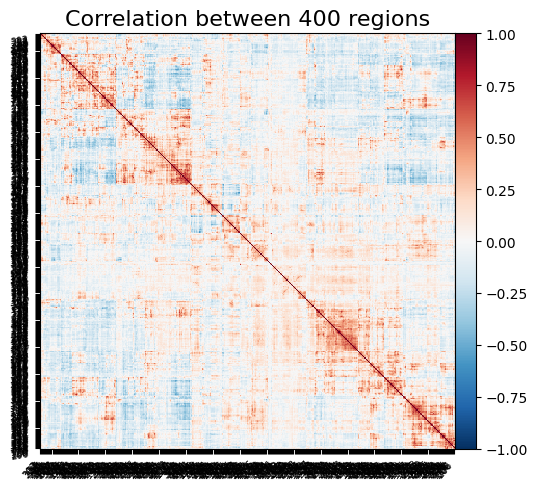

In [ ]:
import h5py
import warnings
warnings.filterwarnings(action='once')
import numpy as np
import nilearn.connectome

file_path = '/content/drive/MyDrive/BrainHack_2024_2/sub-03/sub-03_task-friends_space-T1w_atlas-Ward_desc-400_timeseries.h5'
# Open the HDF5 file
X = np.zeros((453,400))
with h5py.File(file_path, 'r') as f:
    # Print all keys in the file
    print("Keys in the HDF5 file:", list(f.keys()))
    print(len(list(f.keys())))
    # Access a specific dataset
    dataset_name = 'ses-030'
    #dataset_name = 'airbag_01b'
    session_type = 'ses-041_task-s04e04a_timeseries'
    #session_type = 'betas'
    if dataset_name in f:
        data = f[dataset_name]
        for ss_type in data.keys():
          print(f"Data in {dataset_name}:")
          print(data.keys())
          print(f"Data in {ss_type}:")
          print(data[ss_type])
          X = np.concatenate((X, np.array(data[ss_type])), axis=0)
    else:
        print(f"Dataset {dataset_name} not found in the file.")

#print(X)

# Estimating connectomes and save for pytorch to load
print('session SHAPE',X.shape)
corr_measure = nilearn.connectome.ConnectivityMeasure(kind="correlation")
conn = corr_measure.fit_transform([X])[0]

n_regions_extracted = X.shape[-1]
title = 'Correlation between %d regions' % n_regions_extracted

print('Correlation matrix shape:',conn.shape)

# First plot the matrix
from nilearn import plotting
display = plotting.plot_matrix(conn, vmax=1, vmin=-1,
                               colorbar=True, title=title,reorder=True, labels= np.arange(1,401))

###**Cutting Percentile**
As we have seen in the previous cell, the connectome is a dense graph (the adjecency matrix). Therefore to represent our network, we need to pick the top 10 percentile of its weight distribution. Here first we have plotted the distribution of the connectom weights, and then plots the top 10 percentile connectome in the next image. As you can see the output graph is spars and has most informative clusters in different regions.  

0.21622188185501867
82910


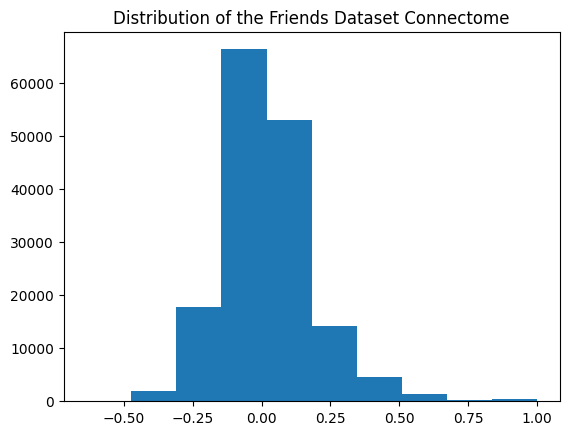

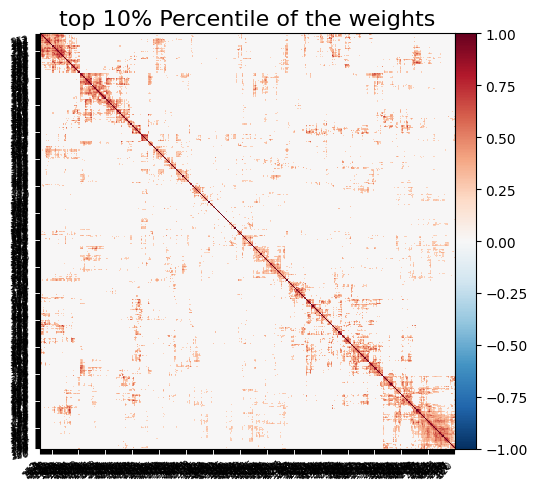

In [ ]:
import numpy
import matplotlib.pyplot as plt
percentile = numpy.percentile(conn.ravel(), q=90)
print(percentile)
print(sum(sum(conn>0)))
plt.hist(conn.ravel())
plt.title('Distribution of the Friends Dataset Connectome')
conn[conn<percentile] = 0
from nilearn import plotting
display = plotting.plot_matrix(conn, vmax=1, vmin=-1,
                               colorbar=True, title='top 10% Percentile of the weights',reorder=True, labels= np.arange(1,401))

### **Graph Construction**
After cleaning up the connectome, we can makeup our graph, by calling `make_group_graph`. Please note that the implementation of the below cell is ispired by [here](https://github.com/main-educational/brain_encoding_decoding/blob/main/src/), However it has been slightly modified, to pure adjecency matrix recostruction for the purpose of this note book.  

In [ ]:
import sys
sys.path.append('../src')
sys.path.append('/content/drive/MyDrive/BrainHack_2024_2/Code')
#from graph_construction import make_group_graph


import numpy as np
import torch
import torch_geometric as tg

def _make_undirected(mat):
    """
    Takes an input adjacency matrix and makes it undirected (symmetric).

    Parameter
    ----------
    mat: array
        Square adjacency matrix.
    """
    if mat.shape[0] != mat.shape[1]:
        raise ValueError("Adjacency matrix must be square.")

    sym = (mat + mat.transpose()) / 2
    if len(np.unique(mat)) == 2:  # if graph was unweighted, return unweighted
        return np.ceil(sym)  # otherwise return average
    return sym

def graph_quantile(mat, self_loops=False, symmetric=True):
    """
    Parameters
    ----------
    mat: array
        Square adjacency matrix.
    Returns:
    Symmetric Adj Matrix
    """

    if mat.shape[0] != mat.shape[1]:
        raise ValueError("Adjacency matrix must be square.")
    dim = mat.shape[0]
    is_directed = not (mat == mat.transpose()).all()
    if is_directed:
        raise ValueError(
            "Input adjacency matrix must be undirected (matrix symmetric)!"
        )

    # absolute correlation
    #mat = np.abs(mat)
    adj = np.copy(mat)
    if not self_loops:
        np.fill_diagonal(adj, 0)
    if symmetric:
        adj = _make_undirected(adj)
    return adj

def make_group_graph(connectomes, self_loops=False, symmetric=True):
    """
    Parameters
    ----------
    connectomes: list of array
        List of connectomes in n_roi x n_roi format, connectomes must all be the same shape.
    self_loops: bool, default=False
        Wether or not to keep self loops in graph, if set to False resulting adjacency matrix
        has zero along diagonal.
    symmetric: bool, default=True
        Wether or not to return a symmetric adjacency matrix. In cases where a node is in the neighbourhood
        of another node that is not its neighbour, the connection strength between the two will be halved.
    """
    if connectomes[0].shape[0] != connectomes[0].shape[1]:
        raise ValueError("Connectomes must be square.")

    # Group average connectome and nndirected 8 k-NN graph
    avg_conn = np.array(connectomes).mean(axis=0)
    avg_conn = np.round(avg_conn, 6)
    avg_conn_k = graph_quantile(
        avg_conn, self_loops=self_loops, symmetric=symmetric
    )

    # Format matrix into graph for torch_geometric
    adj_sparse = tg.utils.dense_to_sparse(torch.from_numpy(avg_conn_k))
    return tg.data.Data(edge_index=adj_sparse[0], edge_attr=adj_sparse[1])

# make a graph for the subject
graph = make_group_graph([conn], self_loops=False, symmetric=True)

### **Random Graph**
Here we also make random graph which its weights has $w\sim N(0,1)$, as a base line for comparing the message passing procedure in connectome and random graph. The first image depicts the weight distribution and the second one represents the connectome of the random graph.  

(400, 400)
1.2818425145007177
80097


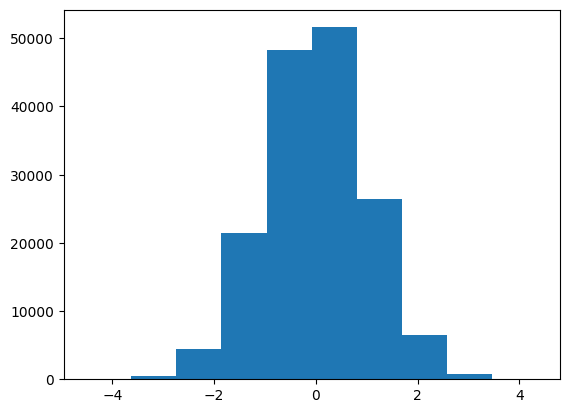

In [ ]:
import numpy as np
print(conn.shape)
rand_conn = np.random.normal(0, 1, size=conn.shape)
percentile = numpy.percentile(rand_conn.ravel(), q=90)
print(percentile)
print(sum(sum(rand_conn>0)))
plt.hist(rand_conn.ravel())
plt.title('Distribution of the Random Gaussian Connectome')
rand_conn[rand_conn<percentile] = 0
graph_rnd = make_group_graph([_make_undirected(rand_conn)], self_loops=False, symmetric=True)

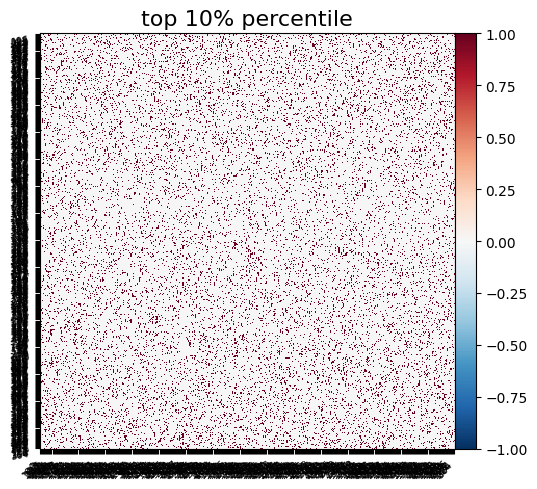

In [ ]:
from nilearn import plotting
display = plotting.plot_matrix(rand_conn, vmax=1, vmin=-1,
                               colorbar=True, title='top 10% percentile',reorder=True, labels= np.arange(1,401))

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/BrainHack_2024_2/Code')
from gcn_windows_dataset import TimeWindowsDataset

In this cell we simply load the dataset with its generalized categories for visualization. Here for this notebook, we use the eight veriosn categories.

In [ ]:
import pickle
with open('/content/drive/MyDrive/Top_5_Label_Data.pkl', 'rb') as f:
    top_5_label_data = pickle.load(f)


import pickle
with open('/content/drive/MyDrive/Top_8_Label_Data.pkl', 'rb') as f:
    top_8_label_data = pickle.load(f)

import numpy as np
combined_label_data = {}

for key, value in top_8_label_data.items():
    beta_parcel = value['beta_parcel']
    label = value['label']

    if label not in combined_label_data:
        combined_label_data[label] = beta_parcel
    else:
        combined_label_data[label] = np.vstack((combined_label_data[label], beta_parcel))
print(combined_label_data['animal'].shape)
concat_bold = combined_label_data

(336, 400)


## **Train, Validation, Test**
In this section, we will talk about the dataset manipulation, and preprocessing stages for GNN netwrok training.

### **Split Dataset**
Here splilit the dataset to three section: train, validation and test.
As the first step, the dataset is trasformed into the standard format as implemeted [here](https://github.com/main-educational/brain_encoding_decoding/blob/main/src/gcn_windows_dataset.py).

In [ ]:
import os
import pandas as pd

data_dir = os.path.join('..', 'data')
categories = concat_bold.keys()
# split the data by time window size and save to file
window_length = 1
dic_labels = {name: i for i, name in enumerate(categories)}

# set output paths
split_path = os.path.join(data_dir, 'split_win/')
if not os.path.exists(split_path):
    os.makedirs(split_path)
out_file = os.path.join(split_path, '{}_{:04d}.npy')
out_csv = os.path.join(split_path, 'labels.csv')

label_df = pd.DataFrame(columns=['label', 'filename'])
for label, ts_data in concat_bold.items():
    ts_duration = len(ts_data)
    ts_filename = f"{label}_seg"
    valid_label = dic_labels[label]

    # Split the timeseries
    rem = ts_duration % window_length
    n_splits = int(np.floor(ts_duration / window_length))

    ts_data = ts_data[:(ts_duration - rem), :]

    for j, split_ts in enumerate(np.split(ts_data, n_splits)):
        ts_output_file_name = out_file.format(ts_filename, j)

        split_ts = np.swapaxes(split_ts, 0, 1)
        np.save(ts_output_file_name, split_ts)

        curr_label = {'label': valid_label, 'filename': os.path.basename(ts_output_file_name)}
        label_df = label_df.append(curr_label, ignore_index=True)
        #df = pd.concat([label_df, pd.DataFrame([curr_label])], ignore_index=True)
       # label_df = pd.concat([label_df,curr_label],axis=0)

print(label_df)
label_df.to_csv(out_csv, index=False)

/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])  # type: ignore[arg-type]


     label                       filename
0        0            animal_seg_0000.npy
1        0            animal_seg_0001.npy
2        0            animal_seg_0002.npy
3        0            animal_seg_0003.npy
4        0            animal_seg_0004.npy
...    ...                            ...
1309     7  sports equipment_seg_0091.npy
1310     7  sports equipment_seg_0092.npy
1311     7  sports equipment_seg_0093.npy
1312     7  sports equipment_seg_0094.npy
1313     7  sports equipment_seg_0095.npy

[1314 rows x 2 columns]


<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

In [ ]:
# split dataset
import sys
sys.path.append('/content/drive/MyDrive/BrainHack_2024_2/Code')
from gcn_windows_dataset import TimeWindowsDataset

random_seed = 0

train_dataset = TimeWindowsDataset(
    data_dir=split_path,
    partition="train",
    random_seed=random_seed,
    pin_memory=True,
    normalize=True,
    shuffle=True)

valid_dataset = TimeWindowsDataset(
    data_dir=split_path,
    partition="valid",
    random_seed=random_seed,
    pin_memory=True,
    normalize=True,
    shuffle=True)

test_dataset = TimeWindowsDataset(
    data_dir=split_path,
    partition="test",
    random_seed=random_seed,
    pin_memory=True,
    normalize=True,
    shuffle=True)

print("train dataset: {}".format(train_dataset))
print("valid dataset: {}".format(valid_dataset))
print("test dataset: {}".format(test_dataset))

train dataset: 919*(torch.Size([400, 1]), ())
valid dataset: 263*(torch.Size([400, 1]), ())
test dataset: 132*(torch.Size([400, 1]), ())


In [ ]:
import torch
from torch.utils.data import DataLoader

batch_size = 10

torch.manual_seed(random_seed)
train_generator = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_generator = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_generator = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
train_features, train_labels = next(iter(train_generator))
print(f"Feature batch shape: {train_features.size()}; mean {torch.mean(train_features)}")
print(f"Labels batch shape: {train_labels.size()}; mean {torch.mean(torch.Tensor.float(train_labels))}")

Feature batch shape: torch.Size([10, 400, 1]); mean 1.2636184543168838e-08
Labels batch shape: torch.Size([10]); mean 2.9000000953674316


## **Building the Graph Convolutional Neural Network Model**
Here we use ChebNet as one the well-know GCN models for graph neural network training. The netwrok consists of three layer of `chebconv` and three fully connected layer followed by a softmax.  `gcn` refers to model based on the Friends dataset connectome, and `gcn_rnd` refers to the model basedd on the random graph.

In [ ]:
from gcn_model import GCN

gcn = GCN(graph.edge_index,
          graph.edge_attr,
          n_roi=X.shape[1],
          batch_size=batch_size,
          n_timepoints=window_length,
          n_classes=len(categories))
model = gcn.double()

In [ ]:
from gcn_model import GCN

gcn_rnd = GCN(graph_rnd.edge_index,
          graph_rnd.edge_attr,
          n_roi=X.shape[1],
          batch_size=batch_size,
          n_timepoints=window_length,
          n_classes=len(categories))
model_rnd = gcn_rnd.double()

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)

    for batch, (X, y) in enumerate(dataloader):
        pred_list = []
        y_list = []
        #print(X.type(), y.type())
        #X,y = X.type(torch.FloatTensor), y.type(torch.FloatTensor)
        X = X.double()
        #y = y.double()
        #X = X.float()
        #y = y.float()
        #print(X.type(), y.type())
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss, current = loss.item(), batch * dataloader.batch_size

        correct = (pred.argmax(1) == y).type(torch.float).sum().item()
        correct /= X.shape[0]
        pred_list.append(pred.argmax(1).numpy())
        y_list.append(y.numpy())
        pred_concat = np.concatenate(pred_list, axis=0)
        y_concat = np.concatenate(y_list, axis=0)
        cheb_f1 = sklearn.metrics.f1_score(y_concat,pred_concat ,average='weighted')
        if (batch % 10 == 0) or (current == size):
            print(f"#{batch:>5};\ttrain_loss: {loss:>0.3f};\ttrain_accuracy:{(100*correct):>5.1f}%\t\t[{current:>5d}/{size:>5d}]\tF1_score(weighted):{cheb_f1}")


def valid_test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    loss, correct = 0, 0
    pred_list = []
    y_list = []
    with torch.no_grad():
        for X, y in dataloader:
            X = X.double()
            pred = model.forward(X)
            loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            pred_list.append(pred.argmax(1).numpy())
            y_list.append(y.numpy())

    loss /= size
    correct /= size
    pred_concat = np.concatenate(pred_list, axis=0)
    y_concat = np.concatenate(y_list, axis=0)
    return loss, correct,y_concat, pred_concat

### **Grpah Training**
Here is the graph training procedure, based on the 25 epochs. as the number of classes is implanced, both of the `F1-score`, and `accuracy` is used for printing in the netwrok output.

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gcn.parameters(), lr=1e-4, weight_decay=5e-4)

epochs = 25
for t in range(epochs):
    print(f"Epoch {t+1}/{epochs}\n-------------------------------")
    train_loop(train_generator, gcn, loss_fn, optimizer)
    loss, correct,y_concat,pred_concat = valid_test_loop(valid_generator, gcn, loss_fn)
    print(f"Valid metrics:\n\t avg_loss: {loss:>8f};\t avg_accuracy: {(100*correct):>0.1f}%")

Epoch 1/25
-------------------------------
#    0;	train_loss: 1.870;	train_accuracy: 20.0%		[    0/  919]	F1_score(weighted):0.1650793650793651
#   10;	train_loss: 1.907;	train_accuracy: 30.0%		[  100/  919]	F1_score(weighted):0.13846153846153847
#   20;	train_loss: 2.140;	train_accuracy: 10.0%		[  200/  919]	F1_score(weighted):0.16
#   30;	train_loss: 1.643;	train_accuracy: 50.0%		[  300/  919]	F1_score(weighted):0.4493506493506493
#   40;	train_loss: 1.839;	train_accuracy: 50.0%		[  400/  919]	F1_score(weighted):0.41666666666666663
#   50;	train_loss: 1.939;	train_accuracy: 30.0%		[  500/  919]	F1_score(weighted):0.20606060606060606
#   60;	train_loss: 2.067;	train_accuracy: 20.0%		[  600/  919]	F1_score(weighted):0.08888888888888889
#   70;	train_loss: 1.717;	train_accuracy: 50.0%		[  700/  919]	F1_score(weighted):0.4036363636363637
#   80;	train_loss: 1.751;	train_accuracy: 20.0%		[  800/  919]	F1_score(weighted):0.06666666666666668
#   90;	train_loss: 1.667;	train_accuracy: 50.0%

### **Random grpah Training**
Same procedure as explained for the initial graph, happenes for the Random graph training as well.

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gcn_rnd.parameters(), lr=1e-4, weight_decay=5e-4)

epochs = 25
for t in range(epochs):
    print(f"Epoch {t+1}/{epochs}\n-------------------------------")
    train_loop(train_generator, gcn_rnd, loss_fn, optimizer)
    loss_rnd, correct_rnd,y_concat_rnd,pred_concat_rnd = valid_test_loop(valid_generator, gcn_rnd, loss_fn)
    print(f"Valid metrics:\n\t avg_loss: {loss_rnd:>8f};\t avg_accuracy: {(100*correct_rnd):>0.1f}%")

Epoch 1/25
-------------------------------
#    0;	train_loss: 2.075;	train_accuracy:  0.0%		[    0/  919]	F1_score(weighted):0.0
#   10;	train_loss: 1.980;	train_accuracy: 30.0%		[  100/  919]	F1_score(weighted):0.13846153846153847
#   20;	train_loss: 2.105;	train_accuracy:  0.0%		[  200/  919]	F1_score(weighted):0.0
#   30;	train_loss: 1.712;	train_accuracy: 20.0%		[  300/  919]	F1_score(weighted):0.17222222222222222
#   40;	train_loss: 2.068;	train_accuracy: 20.0%		[  400/  919]	F1_score(weighted):0.06666666666666668
#   50;	train_loss: 1.928;	train_accuracy: 20.0%		[  500/  919]	F1_score(weighted):0.06666666666666668
#   60;	train_loss: 1.978;	train_accuracy: 10.0%		[  600/  919]	F1_score(weighted):0.01818181818181818
#   70;	train_loss: 1.838;	train_accuracy: 50.0%		[  700/  919]	F1_score(weighted):0.37948717948717947
#   80;	train_loss: 1.936;	train_accuracy: 20.0%		[  800/  919]	F1_score(weighted):0.16
#   90;	train_loss: 2.314;	train_accuracy: 10.0%		[  900/  919]	F1_score(weig

### **Other methods**
To compare the accuracy of the method with a baseline, we use SVM and DummyClassfier, implemntend in `sklearn`. Then we will print the `F1 score` and `accuracy` for further comparison. In addition, we will also plot the confusion matrix for a detailed analysis of the classifiers.

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import sklearn.metrics
import numpy as np
from sklearn import svm
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
# Extract data from DataLoader
X_list = []
y_list = []

for batch, (X, y) in enumerate(train_generator):
    X_list.append(X.numpy())
    y_list.append(y.numpy())

for batch, (X, y) in enumerate(valid_generator):
    X_list.append(X.numpy())
    y_list.append(y.numpy())

for batch, (X, y) in enumerate(test_generator):
    X_list.append(X.numpy())
    y_list.append(y.numpy())

# Concatenate all batches
X = np.concatenate(X_list, axis=0).squeeze(-1)
y = np.concatenate(y_list, axis=0)

# Check shapes
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

# Initialize scikit-learn models
svm_model = svm.SVC()
dummy_model = DummyClassifier(strategy="most_frequent")

# Train and evaluate SVM model
svm_model.fit(X_train, y_train)
svm_predictions = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)
print(f"SVM Accuracy: {svm_accuracy}")

# Train and evaluate DummyClassifier model
dummy_model.fit(X_train, y_train)
dummy_predictions = dummy_model.predict(X_test)
dummy_accuracy = accuracy_score(y_test, dummy_predictions)
print(f"Dummy Classifier Accuracy: {dummy_accuracy}")


print('F1 Score')
dummy_f1 = sklearn.metrics.f1_score(y_test, dummy_predictions,average='weighted')
svm_f1 = sklearn.metrics.f1_score(y_test, svm_predictions,average='weighted')
cheb_f1 = sklearn.metrics.f1_score(y_concat,pred_concat ,average='weighted')
cheb_f1_rnd = sklearn.metrics.f1_score(y_concat_rnd,pred_concat_rnd ,average='weighted')
print('dummy_f1', dummy_f1)
print('svm_f1', svm_f1)
print('Chebnet_f1', cheb_f1)
print('Chebnet_f1_rnd', cheb_f1_rnd)
#sklearn.metrics.f1_score(y_test, dummy_predictions)

Shape of X: (1314, 400)
Shape of y: (1314,)
SVM Accuracy: 0.5399239543726235
Dummy Classifier Accuracy: 0.25475285171102663
F1 Score
dummy_f1 0.10344509736144718
svm_f1 0.46028242034325456
Chebnet_f1 0.5279546214189761
Chebnet_f1_rnd 0.5251744354486851


/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])  # type: ignore[arg-type]


Text(0.5, 1.0, 'ChebNet_Random')

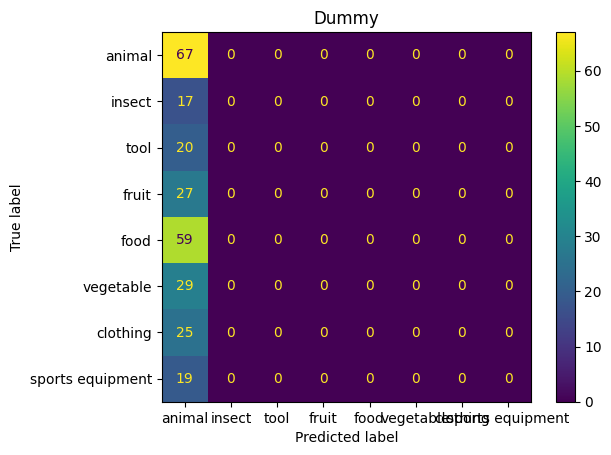

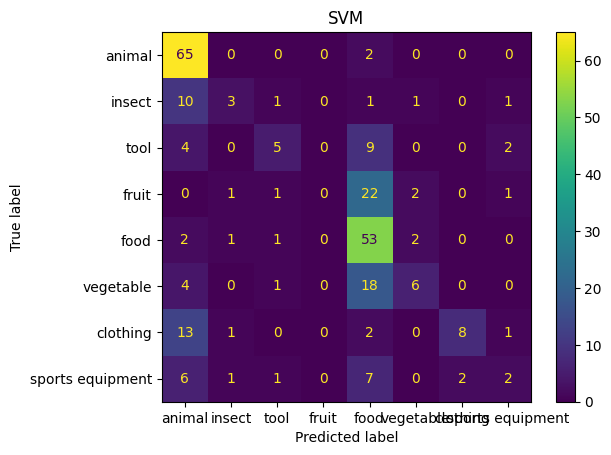

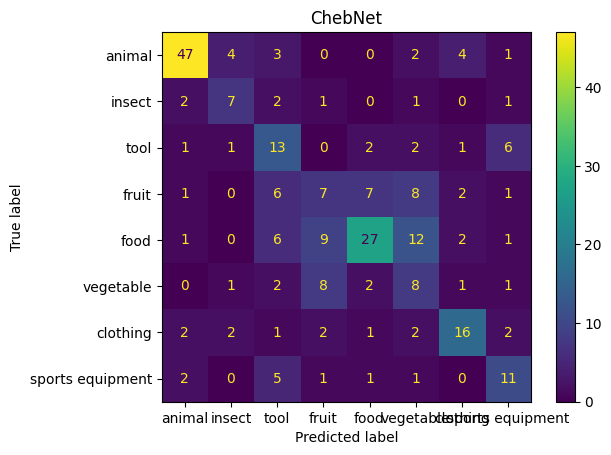

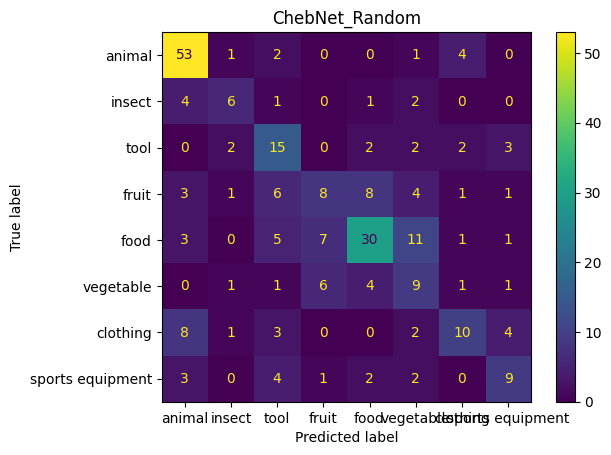

In [ ]:
# Plotting COnfusion Matrix
from sklearn import svm
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
import pandas as pd
label_dict={}
df_label = pd.read_csv('../data/split_win/labels.csv')
for _, row in df_label.iterrows():
    label = row['label']
    filename_prefix = row['filename'].split('_')[0]
    if label not in label_dict:
        label_dict[label] = filename_prefix

cm = confusion_matrix(y_test, dummy_predictions, labels=dummy_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=label_dict.values())

disp.plot()
plt.title("Dummy")

cm = confusion_matrix(y_test, svm_predictions, labels=svm_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=label_dict.values())

disp.plot()
plt.title("SVM")


cm = confusion_matrix(y_concat, pred_concat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=label_dict.values())

disp.plot()
plt.title("ChebNet")


cm = confusion_matrix(y_concat_rnd, pred_concat_rnd)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=label_dict.values())

disp.plot()
plt.title("ChebNet_Random")

### **Disscusion**

As we have seen in above results the accuracy of the `gcn`, and `gcn_rnd` has small differences. Thus, this could be caused either by independency of the underlying graph in the the training and prediction procedure; or it could be caused by the over generalized classes of the dataset. By the way the accuracy of the trained netwroks shows improvement compared to the baseline methods like SVM and Dummy Classifier.  